# Human Genome Language Model

This notebook trains a language model on the human genome, using data prepared in the Data Processing notebook. The language model trained is based on the AWD-LSTM architecture. the genomic input information is split into 8-mers with a stride of 3 bases between each 8-mer. The model is trained to take an input sequence of 8-mers and predict the next 8-mer. This allows us to train a model that learns the structure of genomic information in a totally unsupervised way.

The base of the language model (token embedding + LSTM layers) will then be used to initialize a classification model.

For more detail on how genomic data is processed and how these language models are trained, see the following notebooks:

[E. coli 1 Naive Model](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/E.%20Coli/E.%20coli%201%20Naive%20Model.ipynb)

[E. coli 2 Genomic Pretraining](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/E.%20Coli/E.%20coli%202%20Genomic%20Pretraining.ipynb)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/human/')

In [21]:
df_iter = pd.read_csv(path/'human_genome_data_fa.csv', chunksize=200000)

In [22]:
df = next(df_iter)

In [8]:
df_val = df[:20000]

In [9]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=8, stride=3), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [11]:
data = GenomicTextLMDataBunch.from_df(path, df[20000:], df_val, bs=64, tokenizer=tok, 
                              chunksize=10000, text_cols=0, label_cols=1, max_vocab=80000)

In [12]:
len(data.vocab.stoi), len(data.vocab.itos)

(65537, 65537)

In [13]:
np.save(path/'human_vocab_8mer.npy', data.vocab.itos)

In [10]:
voc = np.load(path/'human_vocab_8mer.npy')
model_vocab = GenomicVocab(voc)

In [11]:
data = GenomicTextLMDataBunch.from_df(path, df[20000:], df_val, bs=64, tokenizer=tok, vocab=model_vocab, max_vocab=80000,
                              chunksize=10000, text_cols=0, label_cols=1)

In [12]:
len(data.vocab.itos), len(data.vocab.stoi)

(65537, 65537)

In [15]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult=0.3

In [16]:
learn = get_model_LM(data, drop_mult, config)

In [17]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(65537, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(65537, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=65537, bias=True)
    (output_dp): RNNDropout()
  )
)

In [19]:
learn.fit_one_cycle(2, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,3.726784,3.559716,0.163740
2,3.600517,3.434144,0.180791


In [20]:
learn.save('human_large1')

In [21]:
learn.save_encoder('human_large1_enc')

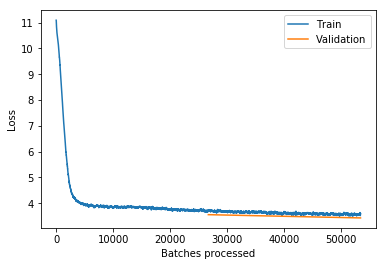

In [21]:
learn.recorder.plot_losses()

In [18]:
learn.load('human_large1');

In [26]:
count = 0
lr = 1e-2
for df in df_iter:
    data = GenomicTextLMDataBunch.from_df(path, df, df_val, bs=64, tokenizer=tok, vocab=model_vocab, max_vocab=80000,
                                  chunksize=10000, text_cols=0, label_cols=1)
    learn.data = data
    lr_iter = lr/1.5**count
    print(f'Learning Rate: {lr_iter}')
    learn.fit_one_cycle(1, lr, moms=(0.8,0.7), pct_start=0.5)
    count += 1

Learning Rate: 0.01


epoch,train_loss,valid_loss,accuracy
1,3.604334,3.442326,0.180991


Learning Rate: 0.006666666666666667


epoch,train_loss,valid_loss,accuracy
1,3.564396,3.441665,0.181746


Learning Rate: 0.0044444444444444444


epoch,train_loss,valid_loss,accuracy
1,3.548499,3.429257,0.182916


Learning Rate: 0.002962962962962963


epoch,train_loss,valid_loss,accuracy
1,3.544148,3.422073,0.184402


Learning Rate: 0.0019753086419753087


epoch,train_loss,valid_loss,accuracy
1,3.523056,3.423848,0.184727


Learning Rate: 0.0013168724279835392


epoch,train_loss,valid_loss,accuracy
1,3.411056,3.412753,0.185638


Learning Rate: 0.0008779149519890261


epoch,train_loss,valid_loss,accuracy
1,3.391593,3.467791,0.180752


In [27]:
learn.save('human_large2')
learn.save_encoder('human_large1_enc2')